In [1]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
data_dir = "../data/processed"
model_dir = "../data"

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
df_oot = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_360_days.csv'))
model = lightgbm.Booster(model_file = os.path.join(model_dir,'quantile_regression_360_0.5_days_2025-02-23.txt'))

In [4]:
df_oot['unlock_price_usd'] = df_oot['upfront_price_usd'] + df_oot['total_follow_on_revenue_usd']
df_oot['avg_upfront_price_usd'] = np.round((df_oot['upfront_price_usd']/df_oot['count_units']),0)
df_oot['avg_unlock_price_usd'] = np.round((df_oot['unlock_price_usd']/df_oot['count_units']),0)
df_oot_copy = df_oot.copy()

In [5]:
X_oot = df_oot.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
                      'actual_fr', 'cohort_age', 'upfront_price_usd', 'unlock_price_usd'], axis=1)
y_oot = df_oot[:]['frr_3_years']

print('shape of the input data: ',X_oot.shape)
print('shape of the output data: ',y_oot.shape)

shape of the input data:  (20154, 73)
shape of the output data:  (20154,)


In [6]:
y_pred_oot = model.predict(X_oot)

df_oot_copy = df_oot.copy()
df_oot_prod = df_oot.copy()
df_oot_prod['actual_frr'] = y_oot
df_oot_prod['predicted_frr'] = y_pred_oot

In [7]:
df_oot_prod.head()

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,product_group,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr
0,2022-04_Tanzania_SHS Entry-Level_Muheza_Sun Ki...,14,223.888614,388,0.074292,0.145391,0.195454,0.368320,0.531898,0.666464,...,SHS Entry-Level,Muheza,Sun King Home 120 Plus EasyBuy,40,720,3095.518536,16.0,221.0,0.917919,0.884536
1,2022-07_Uganda_Lanterns_Pallisa_Sun King Boom ...,36,142.362936,394,0.066853,0.121296,0.166502,0.302003,0.429338,0.532782,...,Lanterns,Pallisa,Sun King Boom EasyBuy,37,720,2745.469641,4.0,76.0,0.781466,0.777480
2,2022-03_Tanzania_SHS Entry-Level_Chanika_Sun K...,6,103.538448,371,0.091293,0.156312,0.197027,0.364187,0.503874,0.637750,...,SHS Entry-Level,Chanika,Sun King Home 120 Plus EasyBuy,41,720,1328.398332,17.0,221.0,0.751937,0.802139
3,2022-03_Nigeria_SHS Entry-Level_Amuloko_Sun Ki...,1040,15000.663600,217,0.160094,0.284896,0.407833,0.764550,0.951706,0.980832,...,SHS Entry-Level,Amuloko,Sun King Home 120 EasyBuy 4L,41,540,120065.889443,14.0,115.0,0.996600,0.995837
4,2022-06_Tanzania_Lanterns_Mazimbu_Sun King Boo...,15,77.230425,367,0.077469,0.135092,0.198606,0.354610,0.491341,0.629535,...,Lanterns,Mazimbu,Sun King Boom EasyBuy,38,720,1248.558750,5.0,83.0,0.878828,0.902189


## Evaluation Results - In prod

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math
y_oot = df_oot_prod[df_oot_prod.count_units>0].actual_frr
y_pred_oot = df_oot_prod[df_oot_prod.count_units>0].predicted_frr
results = {
    "rmse": math.sqrt(mean_squared_error(y_oot,y_pred_oot)),
    "mae": mean_absolute_error(y_oot, y_pred_oot),
    "mape": np.mean(np.abs((y_oot - y_pred_oot) / y_oot)),
    "r2": r2_score(y_oot, y_pred_oot),
    "qloss":  mean_pinball_loss(y_oot, y_pred_oot, alpha=0.5)
}

results

{'rmse': 0.05060105371982129,
 'mae': 0.02473136830242729,
 'mape': np.float64(0.03953745155037692),
 'r2': 0.90473168432225,
 'qloss': 0.012365684151213646}

In [9]:
df_oot_prod

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,product_group,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr
0,2022-04_Tanzania_SHS Entry-Level_Muheza_Sun Ki...,14,223.888614,388,0.074292,0.145391,0.195454,0.368320,0.531898,0.666464,...,SHS Entry-Level,Muheza,Sun King Home 120 Plus EasyBuy,40,720,3095.518536,16.0,221.0,0.917919,0.884536
1,2022-07_Uganda_Lanterns_Pallisa_Sun King Boom ...,36,142.362936,394,0.066853,0.121296,0.166502,0.302003,0.429338,0.532782,...,Lanterns,Pallisa,Sun King Boom EasyBuy,37,720,2745.469641,4.0,76.0,0.781466,0.777480
2,2022-03_Tanzania_SHS Entry-Level_Chanika_Sun K...,6,103.538448,371,0.091293,0.156312,0.197027,0.364187,0.503874,0.637750,...,SHS Entry-Level,Chanika,Sun King Home 120 Plus EasyBuy,41,720,1328.398332,17.0,221.0,0.751937,0.802139
3,2022-03_Nigeria_SHS Entry-Level_Amuloko_Sun Ki...,1040,15000.663600,217,0.160094,0.284896,0.407833,0.764550,0.951706,0.980832,...,SHS Entry-Level,Amuloko,Sun King Home 120 EasyBuy 4L,41,540,120065.889443,14.0,115.0,0.996600,0.995837
4,2022-06_Tanzania_Lanterns_Mazimbu_Sun King Boo...,15,77.230425,367,0.077469,0.135092,0.198606,0.354610,0.491341,0.629535,...,Lanterns,Mazimbu,Sun King Boom EasyBuy,38,720,1248.558750,5.0,83.0,0.878828,0.902189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20149,2022-04_Kenya_SHS with TV_Bomet_Sun King Home ...,13,861.713055,633,0.050122,0.082540,0.118286,0.213313,0.297587,0.374138,...,SHS with TV,Bomet,Sun King Home 600 EasyBuy,40,540,9755.111445,66.0,750.0,0.684119,0.723338
20150,2022-07_Kenya_SHS with TV_Bungoma_Sun King Hom...,1,59.150621,633,0.049206,0.095238,0.142857,0.252381,0.360093,0.501892,...,SHS with TV,Bungoma,Sun King Home 600 Easybuy GSM,37,720,697.977332,59.0,698.0,1.000000,0.982741
20151,2022-07_Uganda_SHS with TV_Mukono_Sun King Hom...,10,564.179134,620,0.047941,0.090035,0.131374,0.244057,0.345250,0.441280,...,SHS with TV,Mukono,Sun King Home 600 Mini EasyBuy,37,720,8480.038452,56.0,848.0,0.919620,0.892194
20152,2022-07_Nigeria_SHS with Fan (w/o TV)_Bauchi_S...,99,3522.101544,286,0.120065,0.216774,0.316007,0.611354,0.886048,0.959267,...,SHS with Fan (w/o TV),Bauchi,Sun King Home 600 EasyBuy,37,630,19581.345117,36.0,198.0,0.983506,0.986382


In [10]:
df_oot_prod.sample(n=1).T

,8108
accounts_group,2022-08_Nigeria_SHS with TV_Amuloko_Sun King H...
count_units,1
upfront_price_usd,65.528545
avg_planned_repayment_days,378
frr_30,0.038462
...,...
unlock_price_usd,530.185503
avg_upfront_price_usd,66.0
avg_unlock_price_usd,530.0
actual_frr,0.612308


In [11]:
a = df_oot_prod[df_oot_prod.cohort_age==450].sample(n=1)
a

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,product_group,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr
7203,2022-05_Kenya_SHS with TV_Kisumu_Sun King Home...,47,2575.607754,632,0.041526,0.074508,0.106718,0.187461,0.266807,0.339421,...,SHS with TV,Kisumu,Sun King Home 600 EasyBuy,39,450,31095.316778,55.0,662.0,0.712409,0.7078


In [12]:
a.accounts_group.values[0]

'2022-05_Kenya_SHS with TV_Kisumu_Sun King Home 600 EasyBuy'

In [13]:
df_oot_prod[df_oot_prod.accounts_group=='2022-05_Kenya_SHS Entry-Level_Port Victoria_Sun King Home 120 Plus EasyBuy']

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,product_group,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr
15917,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,SHS Entry-Level,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,0.75531,0.804755


## Expanding Func for Agg

In [14]:
def expand_rows(df, horizon_steps=[360, 450, 540, 630, 720]):
    df_rep = df.loc[df.index.repeat(len(horizon_steps))].copy()
    df_rep["current_horizon"] = np.tile(horizon_steps, len(df))
    df_rep = df_rep[df_rep["current_horizon"] <= df_rep["cohort_age"]]

    feature_cols = [c for c in df.columns if any(c.endswith(f"_{h}") for h in horizon_steps)]
    for col in feature_cols:
        feat_h = int(col.split("_")[-1])
        df_rep.loc[df_rep["current_horizon"] < feat_h, col] = np.nan

    return df_rep.reset_index(drop=True)

df_oot_copy_expanded = expand_rows(df_oot_copy, horizon_steps=[360, 450, 540, 630, 720])

In [15]:
df_oot_copy_expanded[df_oot_copy_expanded.accounts_group=='2022-08_Kenya_SHS Entry-Level Upgrade_Ukunda_Sun King Home 200X EasyBuy']

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,country,product_group,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,current_horizon
27936,2022-08_Kenya_SHS Entry-Level Upgrade_Ukunda_S...,2,8.364392,367,0.080014,0.134959,0.220124,0.413462,0.59581,0.756525,...,Kenya,SHS Entry-Level Upgrade,Ukunda,Sun King Home 200X EasyBuy,36,540,251.935534,4.0,126.0,360
27937,2022-08_Kenya_SHS Entry-Level Upgrade_Ukunda_S...,2,8.364392,367,0.080014,0.134959,0.220124,0.413462,0.59581,0.756525,...,Kenya,SHS Entry-Level Upgrade,Ukunda,Sun King Home 200X EasyBuy,36,540,251.935534,4.0,126.0,450
27938,2022-08_Kenya_SHS Entry-Level Upgrade_Ukunda_S...,2,8.364392,367,0.080014,0.134959,0.220124,0.413462,0.59581,0.756525,...,Kenya,SHS Entry-Level Upgrade,Ukunda,Sun King Home 200X EasyBuy,36,540,251.935534,4.0,126.0,540


In [16]:
X_oot_agg = df_oot_copy_expanded.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','age_in_months',
                      'actual_fr', 'cohort_age', 'upfront_price_usd', 'unlock_price_usd', 'current_horizon'], axis=1)
y_oot_agg = df_oot_copy_expanded[:]['frr_3_years']
print('shape of the input data: ',X_oot_agg.shape)
print('shape of the output data: ',y_oot_agg.shape)

shape of the input data:  (80740, 73)
shape of the output data:  (80740,)


In [17]:
y_pred_oot_agg = model.predict(X_oot_agg)

In [18]:
df_oot_copy_expanded_copy = df_oot_copy_expanded.copy()
df_oot_copy_expanded_copy['actual_frr'] = y_oot_agg
df_oot_copy_expanded_copy['predicted_frr'] = y_pred_oot_agg

In [19]:
df_oot_copy_expanded_copy[df_oot_copy_expanded_copy.accounts_group=='2022-05_Kenya_SHS Entry-Level_Port Victoria_Sun King Home 120 Plus EasyBuy']

,accounts_group,count_units,upfront_price_usd,avg_planned_repayment_days,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,...,area,primary_product,age_in_months,cohort_age,unlock_price_usd,avg_upfront_price_usd,avg_unlock_price_usd,current_horizon,actual_frr,predicted_frr
63893,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,360,0.75531,0.822958
63894,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,450,0.75531,0.821876
63895,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,540,0.75531,0.824513
63896,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,630,0.75531,0.823177
63897,2022-05_Kenya_SHS Entry-Level_Port Victoria_Su...,17,233.911619,368,0.086677,0.141284,0.195815,0.333567,0.451926,0.55491,...,Port Victoria,Sun King Home 120 Plus EasyBuy,39,720,3435.576954,14.0,202.0,720,0.75531,0.804755


In [20]:
df_oot_copy_expanded_final = df_oot_copy_expanded_copy.groupby(["accounts_group", "reg_month", "country", "product_group", "area", "primary_product", "count_units", "total_follow_on_revenue_usd", "actual_frr"]).agg(
    predicted_frr_agg= ("predicted_frr", "mean")
).reset_index()

print(df_oot_copy_expanded_final.shape)
df_oot_copy_expanded_final.head()

(20153, 10)


,accounts_group,reg_month,country,product_group,area,primary_product,count_units,total_follow_on_revenue_usd,actual_frr,predicted_frr_agg
0,2022-03_India_Lanterns_Balangir_Sun King Boom ...,2022-03,India,Lanterns,Balangir,Sun King Boom EasyBuy,2,78.012996,1.0,0.999844
1,2022-03_India_Lanterns_Katihar_Sun King Boom E...,2022-03,India,Lanterns,Katihar,Sun King Boom EasyBuy,6,234.038988,1.0,1.000484
2,2022-03_India_Lanterns_Rajkhariar_Sun King Boo...,2022-03,India,Lanterns,Rajkhariar,Sun King Boom EasyBuy,1,39.006498,1.0,1.000237
3,2022-03_India_Lanterns_Samastipur_Sun King Boo...,2022-03,India,Lanterns,Samastipur,Sun King Boom EasyBuy,1,47.280604,1.0,0.999985
4,2022-03_India_Lanterns_Sitamarhi_Sun King Boom...,2022-03,India,Lanterns,Sitamarhi,Sun King Boom EasyBuy,1,39.006498,1.0,0.999684


## Evaluation Results - Agg

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_pinball_loss
import math
y_pred_agg = df_oot_copy_expanded_final[df_oot_copy_expanded_final.count_units>1].predicted_frr_agg
y_oot_agg = df_oot_copy_expanded_final[df_oot_copy_expanded_final.count_units>1].actual_frr
results = {
    "rmse": math.sqrt(mean_squared_error(y_oot_agg,y_pred_agg)),
    "mae": mean_absolute_error(y_oot_agg, y_pred_agg),
    "mape": np.mean(np.abs((y_oot_agg - y_pred_agg) / y_oot_agg)),
    "r2": r2_score(y_oot_agg, y_pred_agg),
    "qloss":  mean_pinball_loss(y_oot_agg, y_pred_agg, alpha=0.5)
}

results

{'rmse': 0.043112065542757996,
 'mae': 0.026743637067918942,
 'mape': np.float64(0.0386926697845154),
 'r2': 0.8957044297528107,
 'qloss': 0.013371818533959471}

In [22]:
df = pd.merge(left=df_oot_copy_expanded_final, right=df_oot_prod[["accounts_group", "predicted_frr"]], on="accounts_group")
df[df.count_units==1]

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,total_follow_on_revenue_usd,actual_frr,predicted_frr_agg,predicted_frr
2,2022-03_India_Lanterns_Rajkhariar_Sun King Boo...,2022-03,India,Lanterns,Rajkhariar,Sun King Boom EasyBuy,1,39.006498,1.000000,1.000237,0.999999
3,2022-03_India_Lanterns_Samastipur_Sun King Boo...,2022-03,India,Lanterns,Samastipur,Sun King Boom EasyBuy,1,47.280604,1.000000,0.999985,1.000060
4,2022-03_India_Lanterns_Sitamarhi_Sun King Boom...,2022-03,India,Lanterns,Sitamarhi,Sun King Boom EasyBuy,1,39.006498,1.000000,0.999684,0.999990
5,2022-03_India_Lanterns_Sohela_Sun King Boom Ea...,2022-03,India,Lanterns,Sohela,Sun King Boom EasyBuy,1,39.006498,1.000000,1.000318,0.999918
7,2022-03_India_Phones_Balangir_Vivo Y20G,2022-03,India,Phones,Balangir,Vivo Y20G,1,248.223175,1.000000,1.000006,1.000005
...,...,...,...,...,...,...,...,...,...,...,...
20132,2022-08_Zambia_SHS Entry-Level_Kitwe_Sun King ...,2022-08,Zambia,SHS Entry-Level,Kitwe,Sun King Home 120 Plus EasyBuy,1,217.782344,1.000000,1.000607,1.000002
20141,2022-08_Zambia_SHS with TV_Chingola_Sun King H...,2022-08,Zambia,SHS with TV,Chingola,Sun King Home 200X EasyBuy,1,967.921529,0.192308,0.280461,0.273566
20147,2022-08_Zambia_SHS with TV_Luanshya_Sun King H...,2022-08,Zambia,SHS with TV,Luanshya,Sun King Home 600 EasyBuy,1,1161.505835,1.000000,0.811472,0.818721
20148,2022-08_Zambia_SHS with TV_Ndola_Sun King Home...,2022-08,Zambia,SHS with TV,Ndola,Sun King Home 200X EasyBuy,1,967.921529,1.000000,0.855497,0.879591


In [23]:
# df = df[df.count_units>5]

In [24]:
df_oot_prod[["accounts_group", "predicted_frr"]]

,accounts_group,predicted_frr
0,2022-04_Tanzania_SHS Entry-Level_Muheza_Sun Ki...,0.884536
1,2022-07_Uganda_Lanterns_Pallisa_Sun King Boom ...,0.777480
2,2022-03_Tanzania_SHS Entry-Level_Chanika_Sun K...,0.802139
3,2022-03_Nigeria_SHS Entry-Level_Amuloko_Sun Ki...,0.995837
4,2022-06_Tanzania_Lanterns_Mazimbu_Sun King Boo...,0.902189
...,...,...
20149,2022-04_Kenya_SHS with TV_Bomet_Sun King Home ...,0.723338
20150,2022-07_Kenya_SHS with TV_Bungoma_Sun King Hom...,0.982741
20151,2022-07_Uganda_SHS with TV_Mukono_Sun King Hom...,0.892194
20152,2022-07_Nigeria_SHS with Fan (w/o TV)_Bauchi_S...,0.986382


In [25]:
df["predicted_revenue_3_years_agg"] = np.round(df['predicted_frr_agg']*df['total_follow_on_revenue_usd'],2)
df["predicted_revenue_3_years_prod"] = np.round(df['predicted_frr']*df['total_follow_on_revenue_usd'],2)
df["actual_revenue_3_years"] = np.round(df['actual_frr']*df['total_follow_on_revenue_usd'],2)

## Visuals at Country Level

(51, 9)
Country Kenya
MAE agg 0.3%
MAE prod 0.24%


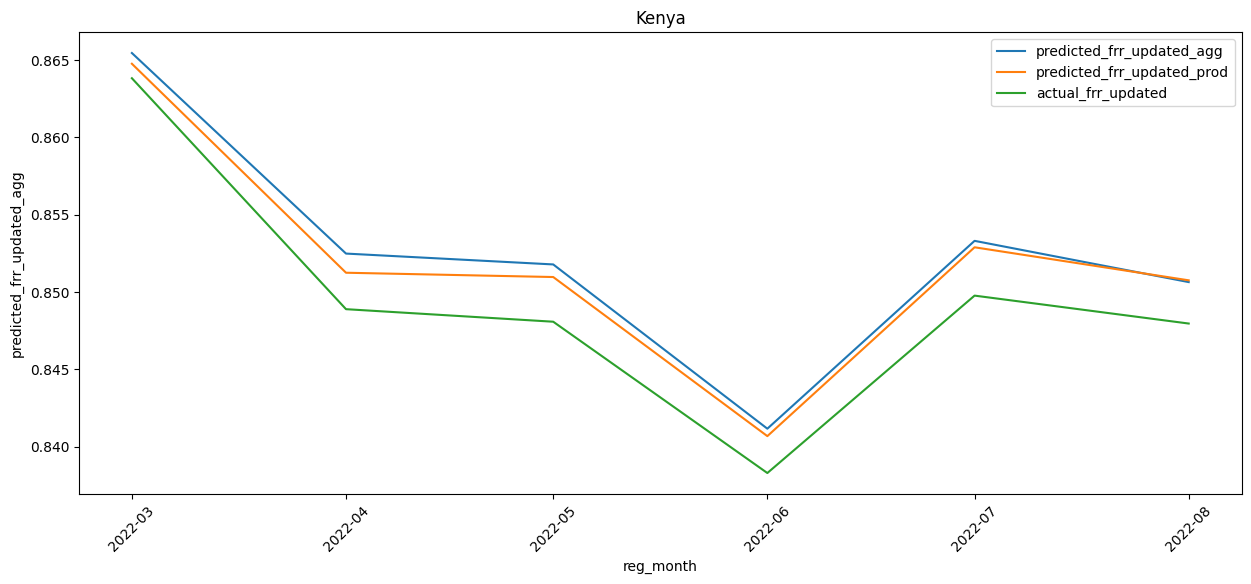

Country Tanzania
MAE agg 1.39%
MAE prod 0.9199999999999999%


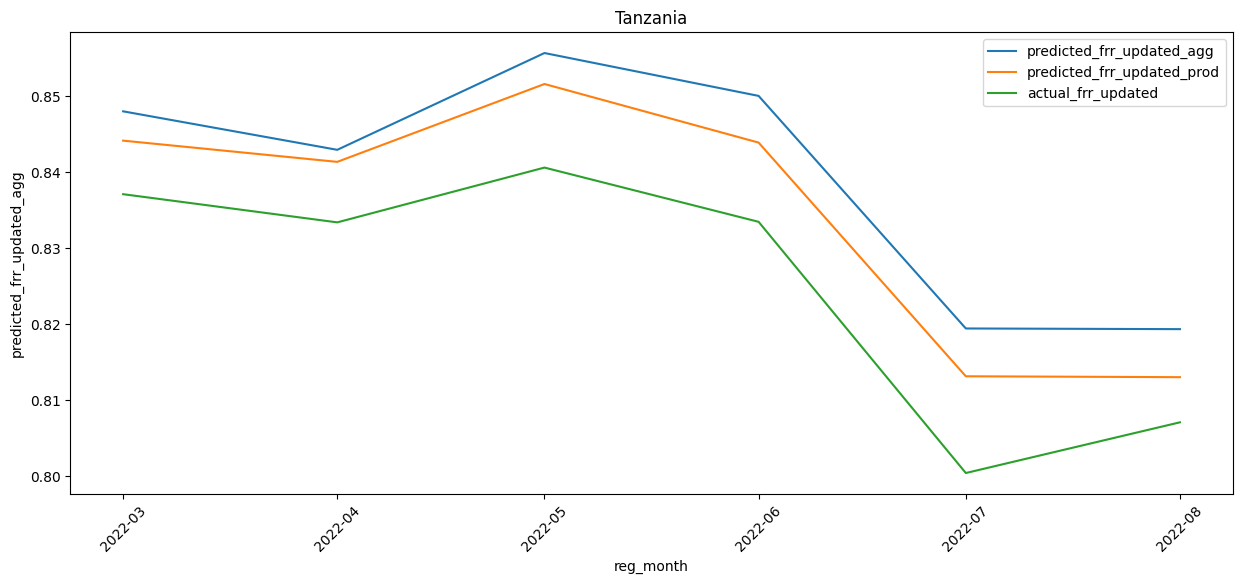

Country Nigeria
MAE agg 0.24%
MAE prod 0.06999999999999999%


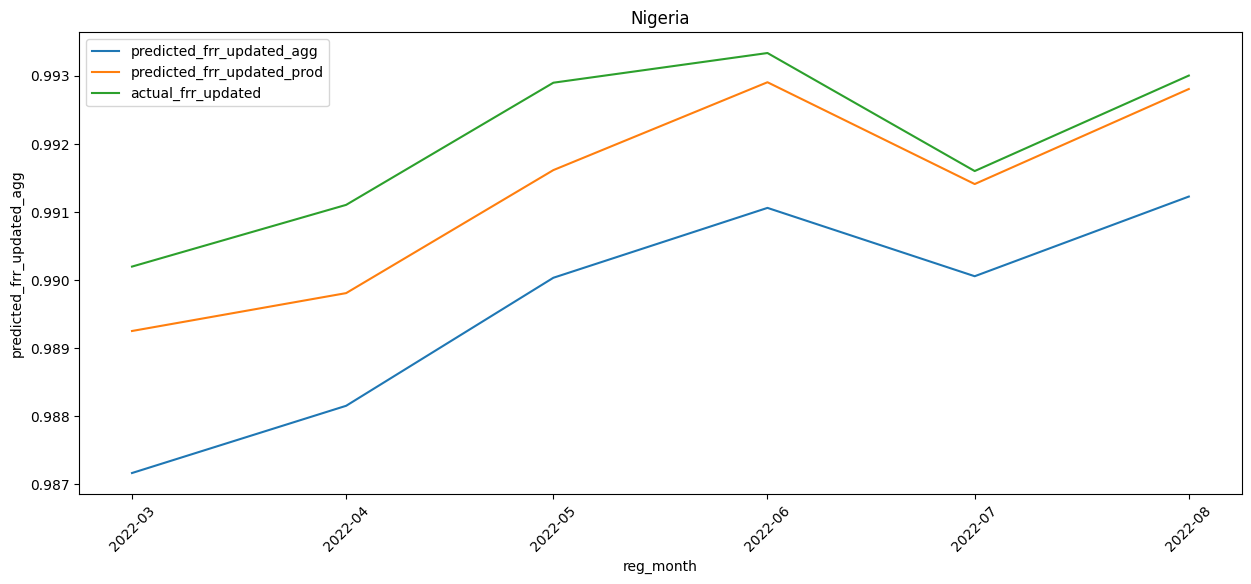

Country Zambia
MAE agg 0.63%
MAE prod 0.65%


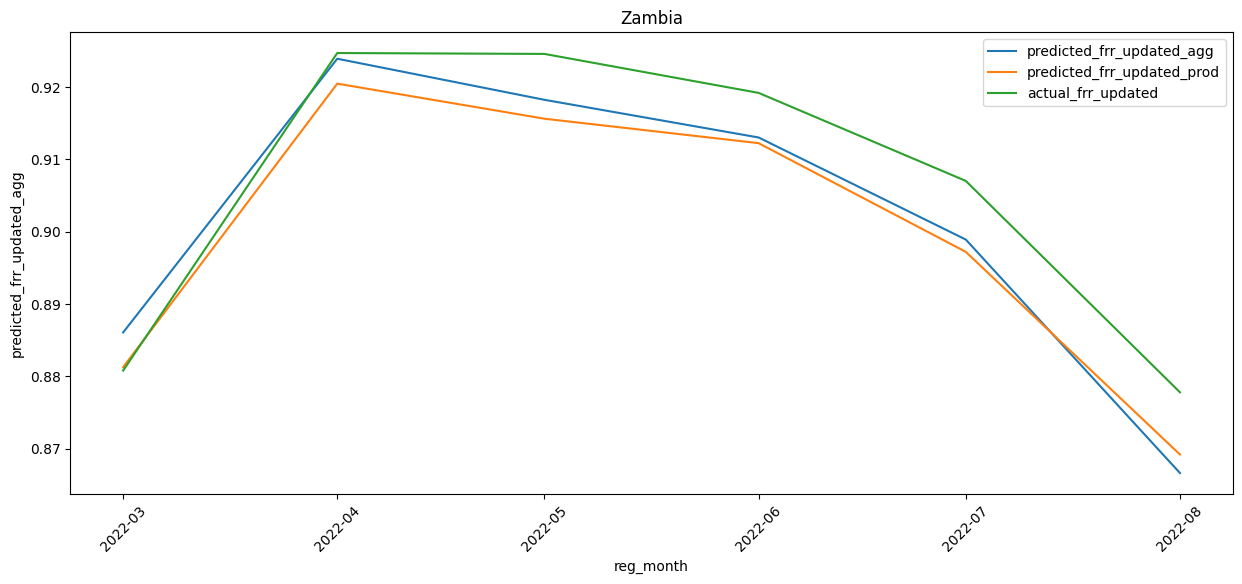

Country Togo
MAE agg 1.53%
MAE prod 1.05%


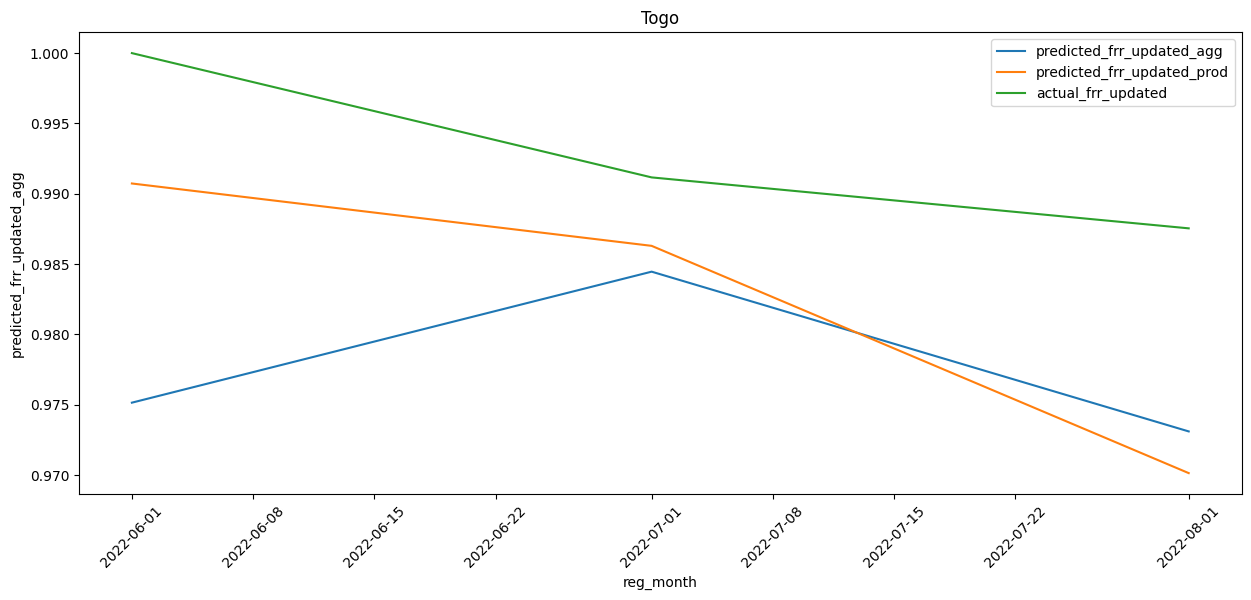

Country Uganda
MAE agg 1.72%
MAE prod 1.03%


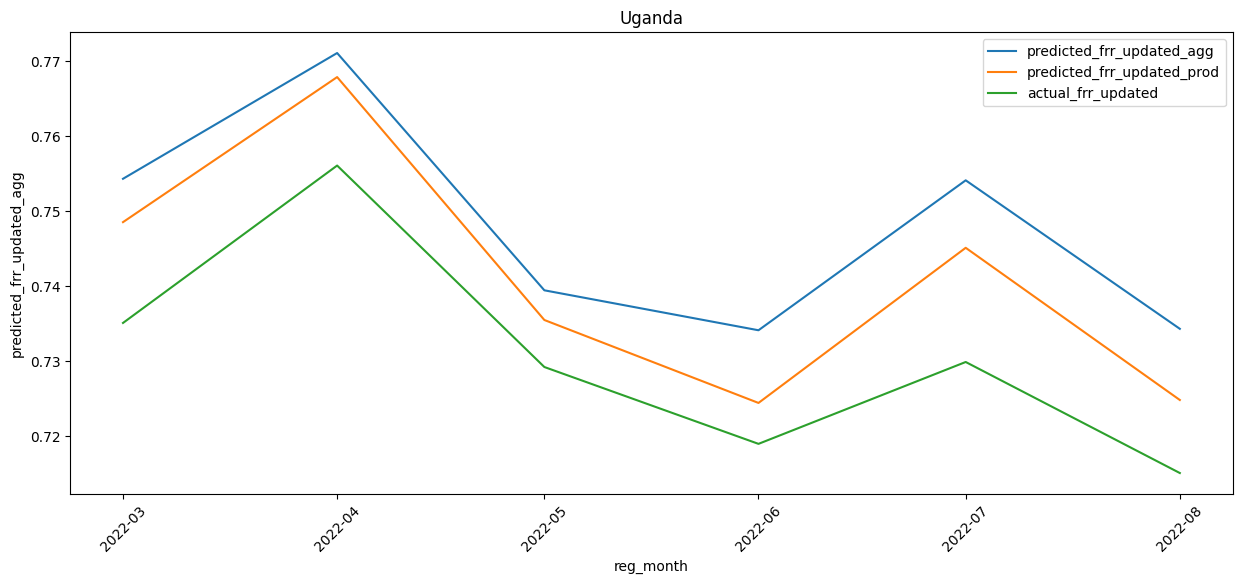

In [26]:
from matplotlib import pyplot as plt
import seaborn as sns

df_country = df.groupby(["country", "reg_month"]).agg(
    count_average=("count_units", lambda x: int(x.mean())),
    predicted_fr_agg = ("predicted_revenue_3_years_agg", "sum"),
    predicted_fr_prod = ("predicted_revenue_3_years_prod", "sum"),
    actual_fr = ("actual_revenue_3_years", "sum"),
    total_fr = ("total_follow_on_revenue_usd", "sum")
).reset_index()
df_country["predicted_frr_updated_agg"] = df_country.predicted_fr_agg/df_country.total_fr
df_country["predicted_frr_updated_prod"] = df_country.predicted_fr_prod/df_country.total_fr
df_country["actual_frr_updated"] = df_country.actual_fr/df_country.total_fr

df_country["diff_agg"] = df_country.predicted_frr_updated_agg - df_country.actual_frr_updated
df_country["diff_prod"] = df_country.predicted_frr_updated_prod - df_country.actual_frr_updated

df_country = df_country.drop(['total_fr', 'predicted_fr_agg', "predicted_fr_prod"], axis=1)
# products = ["Lanterns", "Phones", "SHS Entry-Level", "SHS with TV", "SHS without TV", "SHS Entry-Level Upgrade", "SHS with TV Upgrade"]
# df_country = df_country[df_country.product_group.isin(products)]
df_country["reg_month"] = pd.to_datetime(df_country["reg_month"])
print(df_country.shape)


for country in ["Kenya", "Tanzania", "Nigeria", "Zambia", "Togo", "Uganda"]:
    plt.figure(figsize=(15, 6))
    subset = df_country[(df_country.country==country)]
    print("Country", country)
    print("MAE agg", str(subset.diff_agg.abs().mean().round(4)*100)+"%")
    print("MAE prod", str(subset.diff_prod.abs().mean().round(4)*100)+"%")
    sns.lineplot(data=subset, x="reg_month", y="predicted_frr_updated_agg", label="predicted_frr_updated_agg")
    sns.lineplot(data=subset, x="reg_month", y="predicted_frr_updated_prod", label="predicted_frr_updated_prod")
    sns.lineplot(data=subset,  x="reg_month", y="actual_frr_updated", label="actual_frr_updated")
    # sns.lineplot(data=df_country, x="reg_month", y="frr_prediction_50")
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(country)
    plt.show()